# Races Dataset Understanding

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
from sklearn.impute import KNNImputer
import random
import math
import seaborn as sb
import matplotlib.pyplot as plt
from unidecode import unidecode

In [4]:
cyclists = pd.read_csv("../data/cyclists.csv")

In [5]:
dataset = pd.read_csv("../data/races.csv")
dataset.head(n=5)

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,NaN,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,spain-1991,0.0


## Syntactic and Semantic accuracies analysis

In questa sezione verifichiamo informazioni generiche sui nostri dati. Abbiamo studiato il tipo degli attributi, verificato come questi tipi possano essere cambiati qualora non sinao idonei al dominio degli attributi e abbiamo verificato che i valori non NaN presenti nel dataset risultino all'interno dei rispettivi domini

In [6]:
dataset.info()
# birth year, heigth -> float to int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url                 589865 non-null  object 
 1   name                 589865 non-null  object 
 2   points               589388 non-null  float64
 3   uci_points           251086 non-null  float64
 4   length               589865 non-null  float64
 5   climb_total          442820 non-null  float64
 6   profile              441671 non-null  float64
 7   startlist_quality    589865 non-null  int64  
 8   average_temperature  29933 non-null   float64
 9   date                 589865 non-null  object 
 10  position             589865 non-null  int64  
 11  cyclist              589865 non-null  object 
 12  cyclist_age          589752 non-null  float64
 13  is_tarmac            589865 non-null  bool   
 14  is_cobbled           589865 non-null  bool   
 15  is_gravel        

### Analisi Preliminare

Possiamo osservare che nell'attributo "average_temperature" sono assenti circa il 95% dei valori. La nostra assunzione è quindi che sia impossibile sfruttare questo valore in modo corrertto o correggerlo con una imputazione e pertanto preferiamo rimuoverlo sin da subito per diminuire la dimensionalità del dataset.

Con la stessa analisi appena citata abbiamo rilevato che anche la percentuale di valori mancanti nell'attributo "uci_points" è particolarmente elevata (circa 57%), tuttavia dalle nostre ricerche esterne al dataset, questa categoria di punteggi è stata inventata dopo gli anni 2000, pertanto la mancanza di questi valori potrebbe essere attribuita proprio alla presenza di record risalenti a periodi precedenti alla loro messa in atto. Abbiamo quindi deciso di tenere questi valori nonostante siano assenti nella maggior parte dei record per effettuare analisi mirate

In [7]:
percent_missing = dataset.isnull().sum() * 100 / len(dataset) # compute the percentage of missing values
missing_value_df = pd.DataFrame({'column_name': dataset.columns,
                                 'percent_missing': percent_missing})

missing_value_df['percent_missing']

_url                    0.000000
name                    0.000000
points                  0.080866
uci_points             57.433311
length                  0.000000
climb_total            24.928585
profile                25.123376
startlist_quality       0.000000
average_temperature    94.925449
date                    0.000000
position                0.000000
cyclist                 0.000000
cyclist_age             0.019157
is_tarmac               0.000000
is_cobbled              0.000000
is_gravel               0.000000
cyclist_team           26.982615
delta                   0.000000
Name: percent_missing, dtype: float64

In [8]:
dataset = dataset.drop(columns=['average_temperature'])

In [9]:
dataset.describe()

,points,uci_points,length,climb_total,profile,startlist_quality,position,cyclist_age,delta
count,589388.000000,251086.000000,589865.000000,442820.000000,441671.000000,589865.000000,589865.000000,589752.000000,589865.000000
mean,89.221635,74.601547,166776.180584,2330.469215,2.611611,1101.161178,74.219491,28.486208,418.292794
std,54.435330,100.947962,64545.605664,1375.710722,1.491741,380.586928,48.404023,3.855631,842.961596
min,18.000000,6.000000,1000.000000,2.000000,1.000000,115.000000,0.000000,13.000000,-6906.000000
25%,50.000000,16.000000,152500.000000,1309.000000,1.000000,844.000000,32.000000,26.000000,10.000000
50%,80.000000,60.000000,178200.000000,2255.000000,2.000000,988.000000,70.000000,28.000000,156.000000
75%,100.000000,100.000000,203500.000000,3273.000000,4.000000,1309.000000,112.000000,31.000000,624.000000
max,350.000000,800.000000,338000.000000,6974.000000,5.000000,2047.000000,209.000000,56.000000,61547.000000


### Date Attribute

Poiché l'informazione dell'attributo "date" conteneva dettagli temporali in formato orario, e poiché questi costituiscono più che altro una fonte di rumore per le nostre analisi, abbiamo deciso di rimuovere questa specificità mantenendo un formato "anno-mese-giorno".

Approfittando di questa nuova formattazione abbiamo controllato il primo anno in cui i punteggi "UCI" appaiono nel nostro dataset che confermano la nostra teoria iniziale sull'introduzione di questa valutazione come postumo agli anni 2000

In [10]:
dataset['date'] = dataset['date'].str.split(' ').str[0]
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')

### Name Attribute

Assicuratici dell'assenza di valori NaN, analizzando i nomi dei percorsi nel dataset è emerso che riferendosi alla stessa gara fossero registrati nomi diversi. Dopo aver effettuato delle ricerche online (citazione) per ricavarne i nomi ufficiali abbiamo sostituito tutte le occorrenze varianti con i nomi canonici. 

Notando la dicitura "ME" in alcuni nomi abbiamo effettuato altre ricerche specifiche, scoprendo che questa terminologia si riferisca a "Men Elite" che potrebbe quindi distinguere due classi diverse per la stessa gara. Abbiamo quindi verificato se in uno stesso anno potessero apparire sia la versione ME che la versione non-ME della stessa competizione, scoprendo che in realtà questo non avviene mai. Con questo ragionamento abbiamo quindi determinato che la nomenclatura ME di una competizione non sia altro che un altro sinonimo per il nome canonico della stessa, con cui abbiamo sostituito ogni occorrenza

In [11]:
dataset[dataset['name'].notnull()].groupby(by='name', observed=True)['name'].value_counts()

name
Amstel Gold Race                       4349
Clasica Ciclista San Sebastian         3884
Clásica Ciclista San Sebastian           84
Clásica Ciclista San Sebastián          236
Clásica San Sebastián                    52
                                      ...  
Vuelta Ciclista al País Vasco          6529
Vuelta a España                       89222
Vuelta al País Vasco                   7206
World Championships - Road Race        1611
World Championships ME - Road Race     2306
Name: count, Length: 61, dtype: int64

In [12]:
len(dataset['name'].unique())

61

In [13]:
dataset['name'] = dataset['name'].apply(unidecode)
dataset['name'] = dataset['name'].replace(to_replace={'Clasica Ciclista San Sebastian':'Clasica San Sebastian',
                                                      'Donostia San Sebastian Klasikoa':'Clasica San Sebastian',
                                                         'Criterium du Dauphine Libere':'Criterium du Dauphine',
                                                         'Gran Camino':'O Gran Camino',
                                                         'La Vuelta ciclista a Espana':'Vuelta a Espana',
                                                         'Dwars door Belgie / A travers la Belgique':'Dwars door Vlaanderen',
                                                         'Dwars door Vlaanderen - A travers la Flandre ME':'Dwars door Vlaanderen ME',
                                                         'Dwars door Vlaanderen / A travers la Flandre':'Dwars door Vlaanderen',
                                                         'Dwars door Vlaanderen / A travers la Flandre ME':'Dwars door Vlaanderen ME',
                                                         'E3 BinckBank Classic':'E3 Saxo Bank Classic',
                                                         'E3 Harelbeke':'E3 Saxo Bank Classic',
                                                         'E3 Prijs Vlaanderen':'E3 Saxo Bank Classic',
                                                         'E3 Prijs Vlaanderen - Harelbeke':'E3 Saxo Bank Classic',
                                                         'E3 Saxo Classic':'E3 Saxo Bank Classic',
                                                         'E3-Prijs Harelbeke':'E3 Saxo Bank Classic',
                                                         'Record Bank E3 Harelbeke':'E3 Saxo Bank Classic',
                                                         'Giro di Lombardia':'Il Lombardia',
                                                         'Liege - Bastogne - Liege':'Liege-Bastogne-Liege',
                                                         'Monte Paschi Eroica':'Strade Bianche',
                                                         'Montepaschi Strade Bianche - Eroica Toscana':'Strade Bianche',
                                                         'Omloop Het Volk':'Omloop Nieuwsblad',
                                                         'Omloop Het Nieuwsblad ME':'Omloop Nieuwsblad ME',
                                                         'Omloop Het Volk ME':'Omloop Nieuwsblad ME',
                                                         'Paris - Roubaix':'Paris-Roubaix',
                                                         'Ronde van Vlaanderen - Tour des Flandres ME':'Ronde van Vlaanderen ME',
                                                         'Ronde van Vlaanderen / Tour des Flandres':'Ronde van Vlaanderen',
                                                         'Ronde van Vlaanderen / Tour des Flandres ME':'Ronde van Vlaanderen ME',
                                                         'Volta a Catalunya':'Volta Ciclista a Catalunya',
                                                         'Vuelta Ciclista al Pais Vasco':'Vuelta al Pais Vasco',
                                                         })

In [14]:
len(dataset['name'].unique())

32

In [15]:
tmp_df = tmp_df = pd.DataFrame({
    'name': dataset['name'],
    'year': dataset['date'].dt.year,
    'general_name': dataset['name'].apply(lambda x: x.split('ME')[0].strip()),
})

n_name = tmp_df.groupby(by=['general_name', 'year'], observed=True)['name'].nunique()

n_name_gt1 = n_name[n_name > 1]
round(len(n_name_gt1) / len(n_name) * 100, 2)

0.0

In [16]:
dataset['name'] = dataset['name'].replace(to_replace={
                                                         'Dwars door Vlaanderen ME':'Dwars door Vlaanderen',
                                                         'Omloop Nieuwsblad ME':'Omloop Nieuwsblad',
                                                         'Ronde van Vlaanderen ME':'Ronde van Vlaanderen',
                                                         'World Championships ME - Road Race':'World Championships - Road Race'
                                                         })

### Length Attribute

Nel notebook "races_possible_errors" abbiamo notato che la lunghezza dei percorsi delle gare sia solitamente riconducibile ad un intero, le poche eccezioni sembrano contenere soltato una trascurabilissima quanità di rumore decimale che abbiamo deciso quindi di rimuovere. 

Abbiamo eseguito dei controlli per studiare la variazione dell'attributo "length" degli stage in cui sono suddivise le competizioni rispetto al variare degli anni. Queste analisi hanno portato alla scoperta di un numero consistente di variazioni prossimo all'80%. Basandoci sulle nostre conoscenze attuali e i risultati di queste analisi possiamo ritenere questo comportamento "normale" e dare per assodato che questo attributo non sia statico nel tempo

In [17]:
tmp_df = tmp_df = pd.DataFrame({
    'stage': dataset['_url'].str.split('/').str[-1],
    'name': dataset['name'],
    'year': dataset['date'].dt.year,
    'length': dataset['length'],
    'climb_total': dataset['climb_total'],
    'profile': dataset['profile'],
})

n_length = tmp_df.groupby(['name', 'stage'])['length'].nunique()

n_length_gt1 = n_length[n_length > 1]
round(len(n_length_gt1) / len(n_length) * 100, 2)

79.62

### Climb_total Attribute

Come visto nel notebook "races_possible_errors" il valore climb_total è registrato nel dataset come float ma non presenta cifre decimali. Pertanto senza ulteriori analisi abbiamo deciso di cambiarne il tipo in intero.

Abbiamo eseguito dei controlli per studiare la variazione dell'attributo "climb_total" degli stage in cui sono suddivise le competizioni rispetto al variare degli anni. Queste analisi hanno portato alla scoperta di un numero consistente di variazioni prossimo all'60%. Basandoci sulle nostre conoscenze attuali e i risultati di queste analisi possiamo ritenere questo comportamento "normale" e dare per assodato che questo attributo non sia statico nel tempo.

In [18]:
# climb_total è logicamente un intero
dataset['climb_total'] = dataset[dataset['climb_total'].notnull()]['climb_total'].astype(int)

In [19]:
n_climb = tmp_df.groupby(['name', 'stage'])['climb_total'].nunique()

n_climb_gt1 = n_climb[n_climb > 1]
round(len(n_climb_gt1) / len(n_climb) * 100, 2)

61.15

### Profile Attribute

L'attributo profile è chiaramente categorico. L'unica discrepanza con l'overview dei dati fornitaci con la consegna del progetto è la presenza di un valore in più (da 4 a 5 categorie).
In questa fase tuttavia non riteniamo questa discrepanza essere nociva quanto semplicemente un'occasione per esaminare i profili dei percorsi con una grana più fine. 

Abbiamo eseguito dei controlli per studiare la variazione dell'attributo "profile" degli stage in cui sono suddivise le competizioni rispetto al variare degli anni. Queste analisi hanno portato alla scoperta di un numero consistente di variazioni prossimo all'50%. Basandoci sulle nostre conoscenze attuali e i risultati di queste analisi possiamo ritenere questo comportamento "normale" e dare per assodato che questo attributo non sia statico nel tempo. Il fatto che queste variazioni siano state registrare nell'attributo climb_total quanto nell'attributo length e profile, confermano la nostra ipotesi riguardo al fatto che queste fluttuazioni siano giustificate da frequenti cambiamenti nella delineazione del percorso nelle diverse edizioni delle gare

In [20]:
len(dataset[dataset['profile'].notnull()]['profile'].unique())

5

In [21]:
# 'profile' is clearly a categorical attribute, so we change its type
dataset['profile'] = dataset['profile'].astype('category')

In [22]:
n_profile = tmp_df.groupby(['name', 'stage'])['profile'].nunique()

n_profile_gt1 = n_profile[n_profile > 1]
round(len(n_profile_gt1) / len(n_profile) * 100, 2)

54.23

### Points Attribute

Abbiamo rilevato che l'attributo "points" non si riferisce (al contrario di quanto intuibile) ai punteggi guadagnati da un dato ciclista in un dato stage di una data gara, ma bensì a un valore predefinito a seconda di gara, stage e anno in cui si è tenuta la competizione

In [23]:
dataset.groupby('name')['points'].nunique()

name
Amstel Gold Race                   1
Clasica San Sebastian              2
Criterium du Dauphine              3
Dwars door Vlaanderen              3
E3 Saxo Bank Classic               2
Giro d'Italia                      3
Grand Prix Cycliste de Montreal    1
Grand Prix Cycliste de Quebec      1
Il Lombardia                       1
Itzulia Basque Country             1
La Fleche Wallonne                 1
Liege-Bastogne-Liege               1
Milano-Sanremo                     1
O Gran Camino                      1
Omloop Nieuwsblad                  2
Paris - Nice                       3
Paris-Roubaix                      1
Ronde van Vlaanderen               1
Strade Bianche                     3
Tirreno-Adriatico                  2
Tour de France                     3
Tour de Romandie                   1
Tour de Suisse                     2
UAE Tour                           1
Volta Ciclista a Catalunya         1
Vuelta a Espana                    2
Vuelta al Pais Vasco             

In [24]:
tmp_df = tmp_df = pd.DataFrame({
    '_url': dataset['_url'],
    'name': dataset['name'],
    'year': dataset['date'].dt.year,
    'points': dataset['points'],
    'uci_points': dataset['uci_points']
})

n_points = tmp_df.groupby(['year', 'name'])['points'].nunique()
n_points = n_points[n_points > 1]
n_points

year  name                 
1999  Tour de France           2
2000  Tour de France           2
2001  Tour de France           2
2002  Giro d'Italia            2
      Tour de France           2
2003  Tour de France           2
2004  Tour de France           2
      Vuelta a Espana          2
2005  Criterium du Dauphine    2
      Giro d'Italia            2
      Tour de France           3
      Tour de Suisse           2
      Vuelta a Espana          2
2006  Criterium du Dauphine    3
      Giro d'Italia            2
      Tirreno-Adriatico        2
      Tour de Suisse           2
2008  Paris - Nice             2
      Tirreno-Adriatico        2
2009  Giro d'Italia            3
Name: points, dtype: int64

L'analisi qui sopra rivela che conoscere l'anno in cui si è svolta la competizione e il nome della competizione non ci permette di determinare un univoco punteggio per tutti i record riconducibili a quella coppia competizione-anno. Nell'analisi successiva proviamo allora a distinguere per "_url", attributo che dovrebbe raccogliere informazioni sul nome e anno della competizione, distinugendo però per i vari stage della stessa

In [25]:
n_points = tmp_df.groupby(['name', '_url'])['points'].nunique()
n_points = n_points[n_points > 1]
n_points

Series([], Name: points, dtype: int64)

Abbiamo confermato l'ipotesi iniziale per cui ogni stage di ogni gara ha associato un univoco punteggio nel nostro dataset. Questa peculiarità conferma che il punteggio non è un valore relativo alla posizione di arrivo nella competizione nè un valore che potremmo associare ai ciclisti in maniera diretta. Potrebbe essere comunque interessante in futuro eseguire delle analisi riguardo a correlazione tra ciclisti e punteggi per poter scoprire relazioni inaspettate (ad esempio potremmo scoprire che le gare più prestigiose che danno più punteggi sono frequentate dai ciclisti più prestigiosi)

### UCI Points Attribute

In [26]:
dataset.groupby('name')['uci_points'].nunique()

name
Amstel Gold Race                   1
Clasica San Sebastian              1
Criterium du Dauphine              2
Dwars door Vlaanderen              2
E3 Saxo Bank Classic               1
Giro d'Italia                      3
Grand Prix Cycliste de Montreal    1
Grand Prix Cycliste de Quebec      2
Il Lombardia                       1
Itzulia Basque Country             1
La Fleche Wallonne                 1
Liege-Bastogne-Liege               2
Milano-Sanremo                     2
O Gran Camino                      1
Omloop Nieuwsblad                  2
Paris - Nice                       2
Paris-Roubaix                      2
Ronde van Vlaanderen               2
Strade Bianche                     4
Tirreno-Adriatico                  2
Tour de France                     3
Tour de Romandie                   2
Tour de Suisse                     4
UAE Tour                           1
Volta Ciclista a Catalunya         2
Vuelta a Espana                    2
Vuelta al Pais Vasco             

In [27]:
n_points = tmp_df.groupby(['year', 'name'])['uci_points'].nunique()
n_points = n_points[n_points > 1]
n_points

year  name           
2015  Vuelta a Espana    2
2016  Tour de Suisse     2
Name: uci_points, dtype: int64

In [28]:
n_points = tmp_df.groupby(['name', '_url'])['uci_points'].nunique()
n_points = n_points[n_points > 1]
n_points

Series([], Name: uci_points, dtype: int64)

Anche per l'attributo "uci_points" possiamo confermare quanto detto nel caso precedente. I valori in questo campo dipendono univocamente dalla gara specifica e dallo stage di questa che si sta analizzando

### Url Attribute

In [29]:
result = tmp_df.groupby(['name', 'year'])['_url'].nunique().reset_index()
pivot_result = result.pivot(index='name', columns='year', values='_url')
pivot_result['same_stages_num'] = pivot_result.nunique(axis=1) == 1
pivot_result

year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,same_stages_num
name,,,,,,,,,,,,,,,,,,,,,
Amstel Gold Race,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,True
Clasica San Sebastian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,True
Criterium du Dauphine,2.0,NaN,NaN,NaN,NaN,9.0,NaN,10.0,NaN,1.0,...,7.0,8.0,8.0,7.0,8.0,5.0,8.0,8.0,8.0,False
Dwars door Vlaanderen,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,True
E3 Saxo Bank Classic,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,True
Giro d'Italia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,False
Grand Prix Cycliste de Montreal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,True
Grand Prix Cycliste de Quebec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,True
Il Lombardia,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,True


Abbiamo verificato la variazione degli url negli anni, abbiamo scoperto che nel nostro dataset per la stessa competizione negli anni diversi presenta un numero diverso di stage, questo può essere causato da due fattori:
* Il numero di stage è cambiato negli anni;
* Il nostro dataset è incompleto.

Verificando su internet abbiamo confermato i due fattori sopra citati

### Position Attribute

Attributo "position" rappresenta la posizione di un ciclista nella classifica di una determinata gara. Questo valore è rappresentato come un intero all'interno del dataset e abbiamo discusso se potesse essere rappresentato come categorico. Notando che per gare diverse però il numero delle posizioni totali e di conseguenza il loro valore relativo nella classifca sono differenti abbiamo preferito tenere questo valore in considerazione esclusivamente come un intero poiché altrimenti avremmo che il valore della stessa categoria avrebbe sfumatore di significato differenti in base alla competizione, fattore che ci è sembrato inopportuno per questa tipologia di dati

### Is_foo Attributes

Gli attributi "is_cobbled" e "is_gravel" (come già visto nel notebook races_possible_errors.ipynb) presentano un solo valore (False)e per questo non sono rilevanti in quanto non aggiungono informazioni utili alle nostre analisi. Abbiamo quindi eliminato le due colonne rinominando invece la colonna "is_tarmac" in "mostly_tarmac" integrando quindi l'opinione di un esperto esterno secondo cui il tipo di terreno "tarmac" sia sempre presente (almeno in parte) in tutti i tracciati con però alcuni di questi che presentano soprattutto questa tipologia di terreno.

Abbiamo inoltre verificato che l'attributo "mostly_tarmac" presenta lo stesso valore all'interno di tutti gli stage di ogni gara (fissata un'edizione) e pertanto è un attributo che per noi non simboleggia il tipo di terreno del singolo stage quanto dell'intera gara

In [30]:
dataset = dataset.drop(columns=['is_cobbled', 'is_gravel'])
dataset = dataset.rename(columns={'is_tarmac': 'mostly_tarmac'})

In [31]:
tmp_df = tmp_df = pd.DataFrame({
    'stage': dataset['_url'].str.split('/').str[-1],
    'name': dataset['name'],
    'year': dataset['date'].dt.year,
    'mostly_tarmac': dataset['mostly_tarmac'],
})

n_tarmac = tmp_df.groupby(['name', 'year'])['mostly_tarmac'].nunique()

n_tarmac_gt1 = n_tarmac[n_tarmac > 1]
round(len(n_tarmac_gt1) / len(n_tarmac) * 100, 2)

0.0

### Cyclists and Cyclists Age Attributes

Poiché questi dati sono streattamente correlati con quelli presenti nel dataset "cyclists.csv" riteniamo opportuno poter fare analisi incrociate su gli attributi di entrambe le sorgenti, per questo iniziamo questa sezione con la join dei due dataset. Per comodità abbiamo rinominato alcuni attributi elencati di seguito:
* race_url: url della competizione (_url in races.csv);
* race_name: nome convenzionale della competizione (name in races.csv);
* cyclist_url: url del ciclista (_url in cyclists.csv e cyclist in races.csv);
* cyclist_name: nome del ciclista (name in cyclists.csv).

E' importante evidenziare che i ciclisti registrati nel dataset cyclist.csv ma assenti nel dataset races.csv (guarda notebook "cyclist_understanding") sono stati automaticamente ignorati nel corso dell'operazione di "inner join" e non hanno di conseguenza introdotto valori NaN negli attributi del dataset generato. 

In [32]:
dataset['cyclist_age'] = dataset[dataset['cyclist_age'].notnull()]['cyclist_age'].astype(int)

join_df = dataset.merge(cyclists, how='inner', left_on='cyclist', right_on='_url')
join_df = join_df.drop(columns=['_url_y'])
join_df = join_df.rename(columns={'name_x': 'race_name', 'name_y': 'cyclist_name', 'cyclist':'cyclist_url', '_url_x':'race_url'})

# join_df.to_csv('../data/complete_dataset.csv', index=False)

In [33]:
url_cyclist_count = join_df.groupby('race_url')['cyclist_url'].value_counts()
duplicated_cyclists = url_cyclist_count[url_cyclist_count > 1].reset_index(name='count')
len(duplicated_cyclists)

123

In [34]:
df = join_df[join_df['race_url'].isin(duplicated_cyclists['race_url'].values) & join_df['cyclist_url'].isin(duplicated_cyclists['cyclist_url'].values)]
n_delta = df.groupby(by=['race_url', 'cyclist_url'])['delta'].nunique()
n_delta = n_delta[n_delta > 1]
n_delta

race_url                       cyclist_url              
dauphine/2005/stage-3          ivan-gutierrez               2
dauphine/2005/stage-4          ivan-gutierrez               2
dauphine/2005/stage-6          ivan-gutierrez               2
dauphine/2005/stage-7          ivan-gutierrez               2
dauphine/2012/stage-3          david-moncoutie              2
                                                           ..
vuelta-a-espana/1996/stage-12  inaki-ayarzaguena-urkidi     2
vuelta-a-espana/1996/stage-3   igor-gonzalez-de-galdeano    2
vuelta-a-espana/1997/stage-6   eleuterio-anguita            2
vuelta-a-espana/1997/stage-7   eleuterio-anguita            2
vuelta-a-espana/1997/stage-9   eleuterio-anguita            2
Name: delta, Length: 78, dtype: int64

Calcoliamo un'età presunta attraverso la differenza tra l'anno in cui si svolge una determinata corsa e l'anno di nascità del ciclista che identifica il record. Questa età presunta potrà essere solo uguale o di 1 anno superiore all'età riportata nell'attributo "cyclist_age" del dataset originale. Questo confronto sarà essenziale per determinare la coerenza tra i dati

In [35]:
def compute_presumed_age(row):
    return row['date'].year - row['birth_year']

tmp = join_df[join_df['date'].notnull() & join_df['birth_year'].notnull()].apply(compute_presumed_age, axis=1)
join_df.loc[tmp.index, 'age_presumed'] = tmp.values

In [36]:
join_df.loc[tmp.index, 'age_presumed'] = tmp.values

In [37]:
age_difference = join_df[join_df['cyclist_age'].notnull()]['cyclist_age'] - join_df[join_df['age_presumed'].notnull()]['age_presumed']

Il successivo confronto ha dimostrato che tutte le età presenti nel dataset e gli anni di nascita risultano coerenti tra loro

In [38]:
all(age_difference > 1) or all(age_difference < 0)

False

Now, we check if there we can take some age information from the dataset

In [39]:
# Check if there are any 'cyclist_age' null values, where we have the year of birth in the cyclists dataset
invalid_rows = join_df[join_df['cyclist_age'].isnull() & join_df['birth_year'].notnull()]

print('Number of cyclists with age info in cyclists dataset: ' + str(len(invalid_rows)))

Number of cyclists with age info in cyclists dataset: 0


In [40]:
# TODO check url del cyclista
# Check for cyclists whose age is partially missing (some values present, some missing)
partial_missing_age = join_df.groupby('cyclist_url')['cyclist_age'].apply(lambda x: x.isnull().any() and x.notnull().any())

# Print the number of cyclists with partial missing age data
print('Number of cyclists with partially missing age: ' + str(len(partial_missing_age[partial_missing_age])))


Number of cyclists with partially missing age: 0


### Cyclist Team Attribute

Intuitivamente supponiamo che il team ciclistico fosse un attributo di tipo categorico in quanto descrive una classe di ciclisti appartenente alla stessa squadra. 

In [41]:
join_df[join_df['cyclist_team'].notnull()]['cyclist_team'].value_counts()

cyclist_team
liberty-seguros-wurth-team-2005     8869
roompot-nederlandse-loterij-2018    8773
chazal-vetta-mbk-1993               8094
kondor-1979                         7895
kazakhstan-2019                     7701
                                    ... 
atala-ofmega-1988                   1259
finland-2016                        1236
south-africa-1993                   1174
denmark-2003                         216
quickstep-innergetic-2009              3
Name: count, Length: 91, dtype: int64

Per controllare la coerenza del dataset vogliamo assicurarci del fatto che all'interno della stessa gara il team di ogni ciclista rimanga invariato nei diversi step che compongono questa stessa competizione. Per ogni tupla (cyclist, name, race_year) vogliamo assicurarci che esista un unico valore per l'attributo cyclist_team

In [42]:
tmp_df = join_df
tmp_df['race_year'] = tmp_df['date'].dt.year
tmp_df = tmp_df.drop(columns=['date'])
val = tmp_df.groupby(['cyclist_url', 'race_name', 'race_year']).nunique()['cyclist_team'].values

if len(val[val > 1]) == 0:
    print("All cyclists have always the same team in the same edition of the race")
else:
    print("INCOERENCE: Some cyclists have different teams in the same edition of the race")

All cyclists have always the same team in the same edition of the race


### Delta Attribute

Abbiamo notato principalmente due particolarità nei valori di questo attributo:
* Valori negativi: una piccola percentuale dei valori delta risulta negativa, valore che dovrebbe essere fuori dominio secondo la nostra comprensione e che potrebbe rappresentare o un errore o una situazione rara e particolare (ad esempio l'abbandono della competizione da parte di un ciclista infortunato o altre occorrenze simili);
* Cluster di valori uguali per ciclisti arrivati in posizioni successive: ci saremmo aspettati di trovare valori diversi di delta per ogni ciclista all'interno della stessa competizione, mentre invece interi gruppi di ciclisti appaiono condividere lo stesso delta. Attribuiamo questa peculiarità col fatto che i ciclisti taglino il traguardo in gruppi e il delta misuri più che altro la differenza tra i tempi di arrivo tra questi gruppi.

Abbiamo individuato che 346 stage presentano delta "sospetti", nel senso che per posizioni migliori nella classifica la distanza temporale dello stesso ciclista rispetto al primo classificato risulta però peggiore rispetto a quella dei ciclisti arrivati dopo di lui. Questa peculiarità potrebbe non rappresentare un errore teorico vito il fatto che diverse competizioni ciclistiche tengono in conto altri fattori (tra cui squalifiche postume al termine della gara ed eventuali scorrimenti) e non si limitano al delta come determinante univoco della posizione finale nella classifica (da dimostrare)

In [43]:
len(join_df[join_df['delta'] < 0])

86

In [44]:
#invalid_urls = dataset.groupby('_url').apply(lambda x: (x.shift() > x).any())
sorted_groups = join_df.groupby('race_url').apply(lambda x: x.sort_values('position')).reset_index(drop=True)
invalid_urls = sorted_groups.groupby('race_url')['delta'].apply(lambda x: (x.shift() > x).any())
len(invalid_urls[invalid_urls]) #TODO: trova un modo di fare la stessa cosa senza il warning

/tmp/ipykernel_2782/2572252260.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted_groups = join_df.groupby('race_url').apply(lambda x: x.sort_values('position')).reset_index(drop=True)


346

In [45]:
print(f'Number of duplicates: {len(join_df)-len(join_df.drop_duplicates())}')

Number of duplicates: 0


## Data-Balance Analysis 

In questa sezione studiamo il bilanciamento e la rappresentazione dei vari attributi del dataset

In [46]:
join_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   race_url           589865 non-null  object        
 1   race_name          589865 non-null  object        
 2   points             589388 non-null  float64       
 3   uci_points         251086 non-null  float64       
 4   length             589865 non-null  float64       
 5   climb_total        442820 non-null  float64       
 6   profile            441671 non-null  category      
 7   startlist_quality  589865 non-null  int64         
 8   date               589865 non-null  datetime64[ns]
 9   position           589865 non-null  int64         
 10  cyclist_url        589865 non-null  object        
 11  cyclist_age        589752 non-null  float64       
 12  mostly_tarmac      589865 non-null  bool          
 13  cyclist_team       430704 non-null  object  

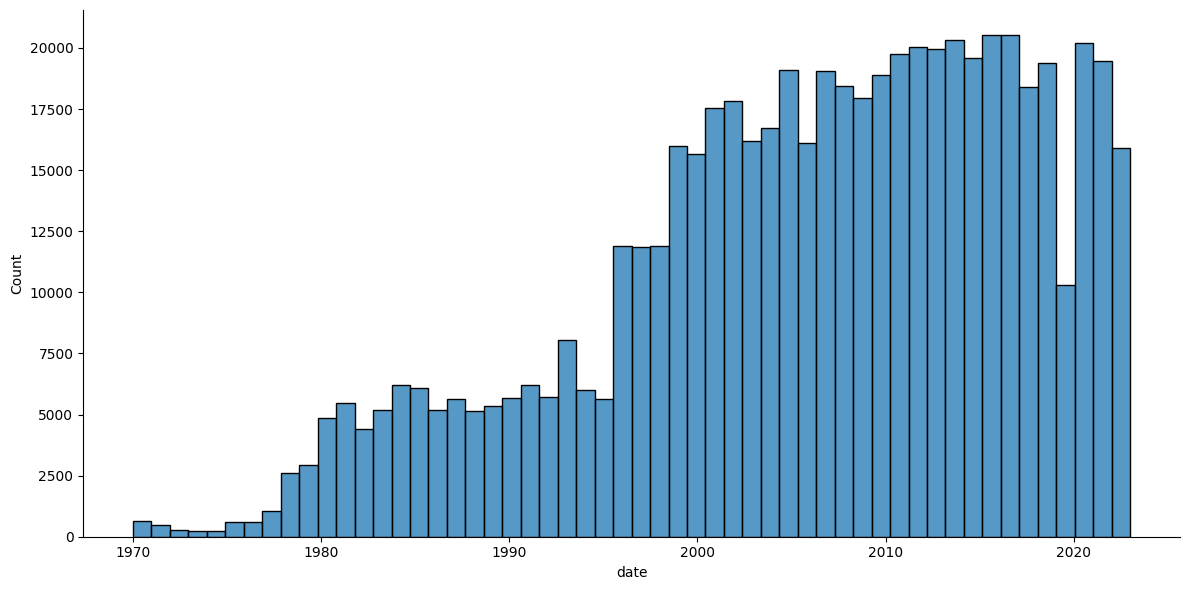

In [47]:
n_bins = math.ceil(math.log2(len(dataset)) + 1)
years = pd.to_datetime(dataset['date'], format='%Y-%m-%d').dt.year

sb.displot(join_df, 
                x=years, 
                kind="hist",
                row_order="desc",
                bins=len(years.unique()),
                height=6,
                aspect=2)

Analizzando la distribuzione degli anni a cui risalgono i contenuti dei vari record presenti nel dataset "races.csv" emerge come i dati più presenti siano quelli successivi agli anni 95 circa. Questo potrebbe essere dovuto al fatto che il ciclismo si sia affermato come sport (con un incremento notevole di importanza) solo in seguito a questa data (da controllare) o dal fatto che la sorgente di questi dati sia diventata un repository di informazioni rilevante soltanto a partire da quell'epoca.

Un'altra caratteristica rilevante riguarda la rappresentazione della classe di date adiacenti al 2020, anno in cui vediamo una netta assenza di informazioni rispetto agli anni circostanti. La spiegazione di questo fenomeno è plausibilmente da ritrovare nella pandemia di Covid-19 che in quel periodo storico ha limitato drasticamente la possibilità di avviare e partecipare a eventi pubblici e sportivi come le gare ciclistiche

In [48]:
tmp_df = pd.DataFrame({
    'race_name': join_df['race_name'],
    'cyclist_name': join_df['cyclist_name'],
    'year': years
})

tmp_df = tmp_df.drop_duplicates()

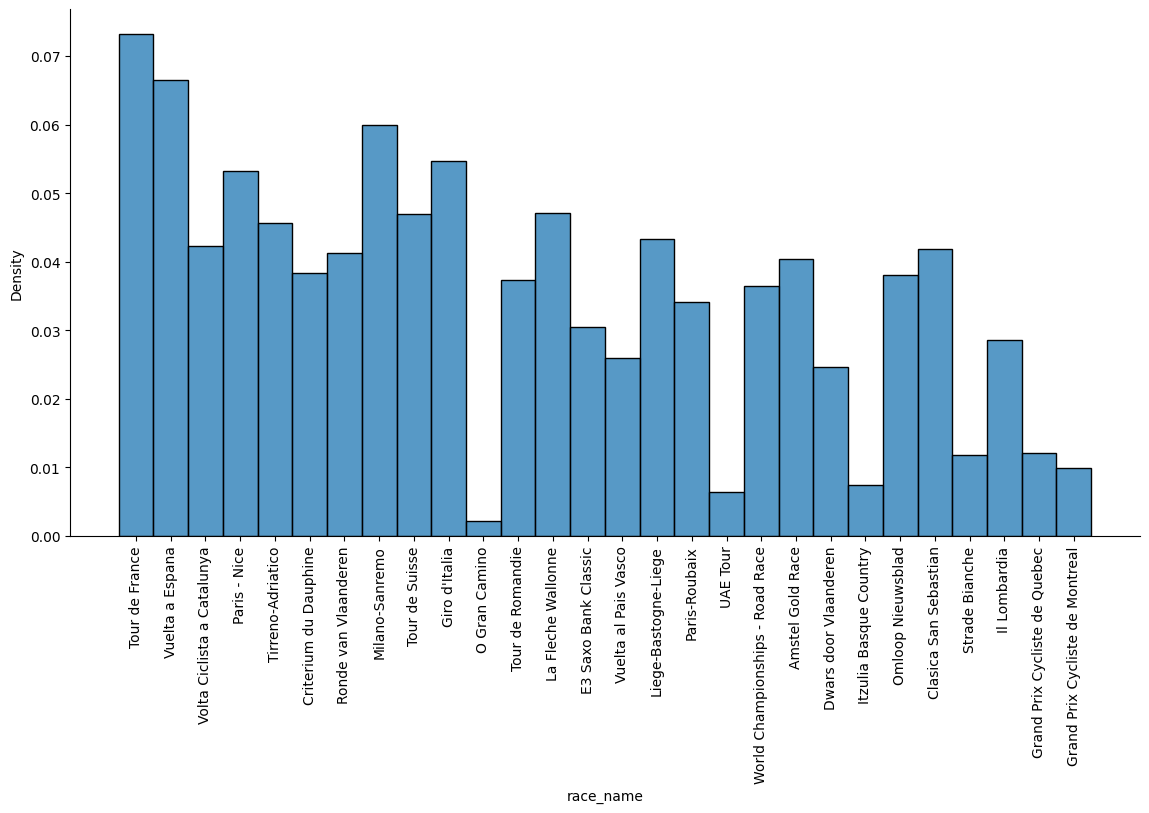

In [49]:
sb.displot(tmp_df, 
                x="race_name", 
                kind="hist",
                row_order="desc",
                bins=len(join_df['race_name'].unique()),
                stat='density',
                height=6,
                aspect=2) 
plt.xticks(rotation=90);

Nel grafico sopra analizziamo la "partecipazione alle gare" secondo i dati del nostro dataset. Per ottenere questo valore il grafico a barre riporta la frequenza in termini di record contenuti nel dataset per ogni differente competizione, assicurandoci di non contare la partecipazione di ogni ciclista ad ogni stage della stessa competizione nel calcolo della frequenza (ogni ciclista viene contato 1 sola volta per ogni coppia competizione-anno). Poiché i record non rappresentano corse quanto ciclisti all'interno di una corsa, questa valutazione ci permette di estrarre la suddetta informazione. 

Studiando questa distribuzione è possibile notare che alcune competizioni come O Gran Camino, UAE Tour, Itzulia Basque Country sono meno rappresentate nel nostro dataset in termini di partecipazione (partecipazione <= 1%)

In [50]:
tmp_df = pd.DataFrame({
    'race_name': join_df['race_name'],
    'year': years
}).drop_duplicates()

n_years_per_race = tmp_df.groupby('race_name')['year'].nunique()

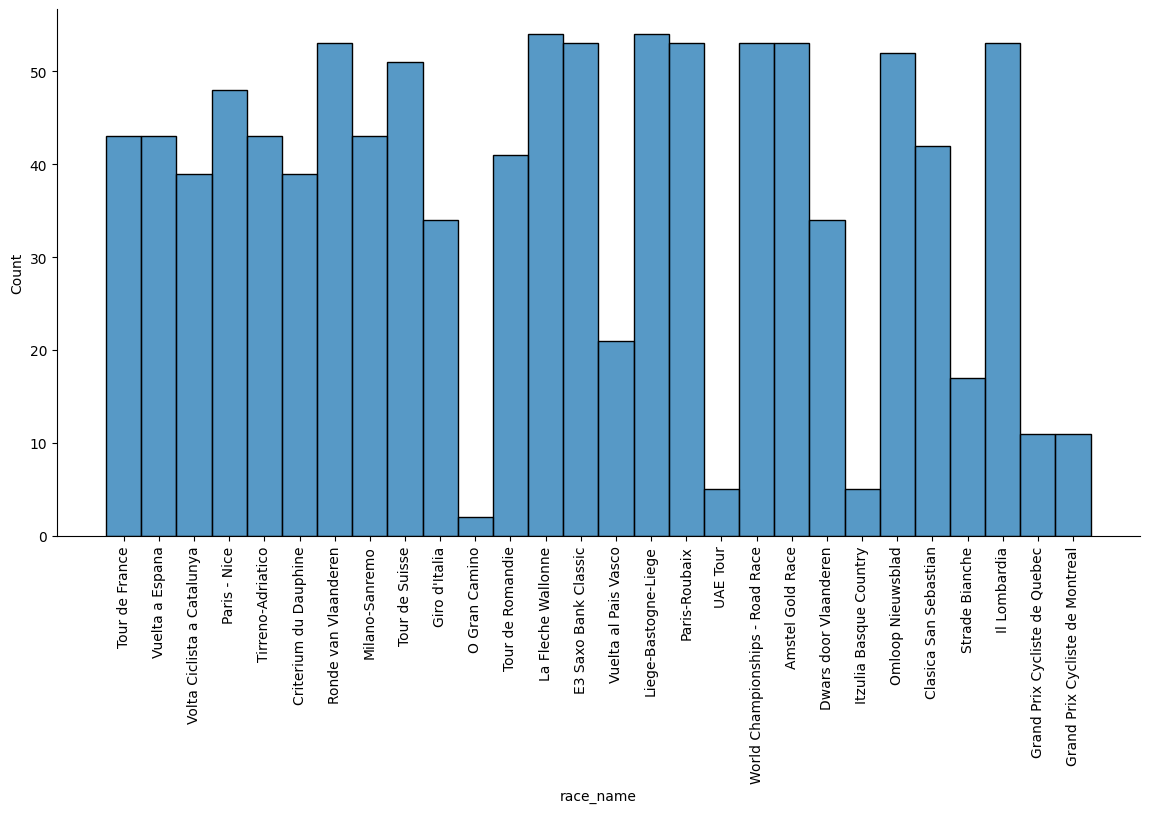

In [51]:
sb.displot(tmp_df, 
                x="race_name", 
                kind="hist",
                row_order="desc",
                bins=len(join_df['race_name'].unique()),
                height=6,
                aspect=2) 
plt.xticks(rotation=90);

Il plot qui sopra mostra la quantità di edizioni di ogni gara rinvenuta nel dataset. Possiamo notare come le gare "meno partecipate" (O Gran Camino, UAE Tour, Itzulia Basque Country) sono in realtà gare di cui abbiamo semplicemente poche tracce nel nostro dataset anche a livello di numero di edizioni registrate

<Axes: xlabel='Mean number of stages', ylabel='race_name'>

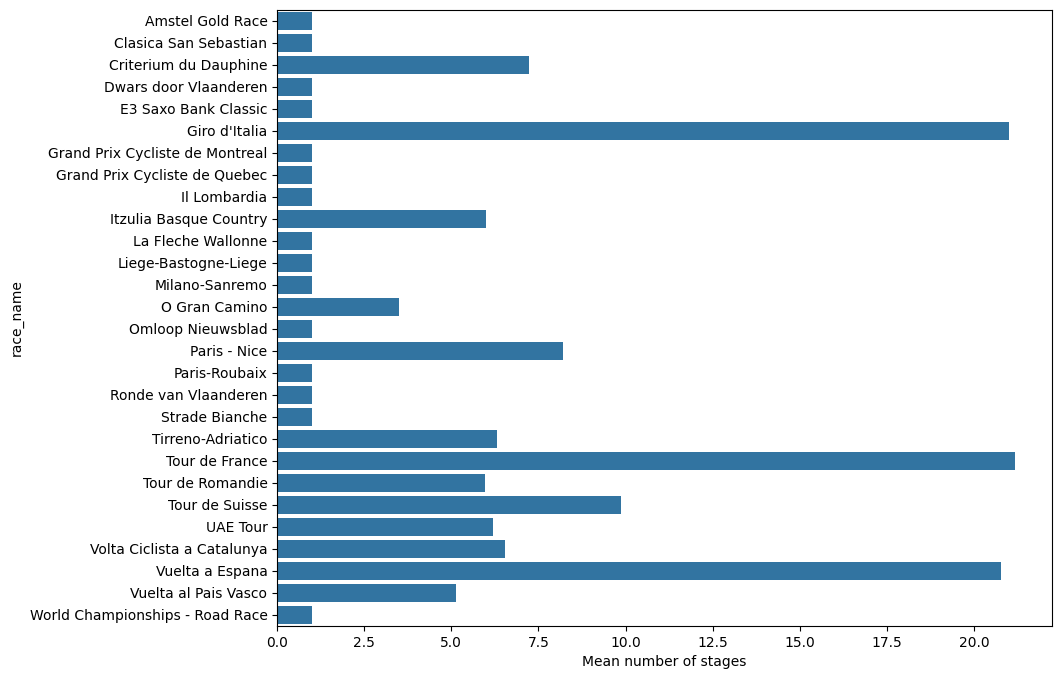

In [52]:
sum_race_url_per_years = join_df.groupby('race_name')['race_url'].nunique()

mean_race_url = sum_race_url_per_years / n_years_per_race

mean_race_df = mean_race_url.reset_index()

plt.figure(figsize=(10, 8))
plt.xlabel('Mean number of stages')
sb.barplot(y='race_name', x=0, data=mean_race_df, orient='h')

Il grafico qui sopra rappresenta il numero medio di stage al variare degli anni per ogni competizione presente nel nostro dataset. Possiamo notare come il fatto che una gara sia più o meno partecipata di un'altra non sembra determinare il numero degli stage di questa (almeno da un'analisi qualitativa). Un esempio di questo comportamento emerge dal confronto della competizion "O Gran Camino" con la competizione "Milano-Sanremo", la prima una delle più basse in termini di partecipazione e la seconda al contrario una delle più partecipate, quest'ultima risulta invece inferiore in temrini di numero di stage (1 stage al confronto con 3/4 a seconda dell'anno). 

Dal grafico emerge anche che la maggior parte (15 su 28) delle competizioni presenti un solo stage (almeno rispetto a quanto registrato nel nostro dataset)

In [53]:
# COSE LOSCHE e DA FARE

'''
    - Manca StartList Quality nella prima analisi sopra
    - Plot multipli (plot più specifici, uno per gara, dove studiamo le distribuzioni medie per gara)
'''

'\n    - Manca StartList Quality nella prima analisi sopra\n    - Plot multipli (plot più specifici, uno per gara, dove studiamo le distribuzioni medie per gara)\n'

### Length Attribute

<Axes: xlabel='length', ylabel='race_name'>

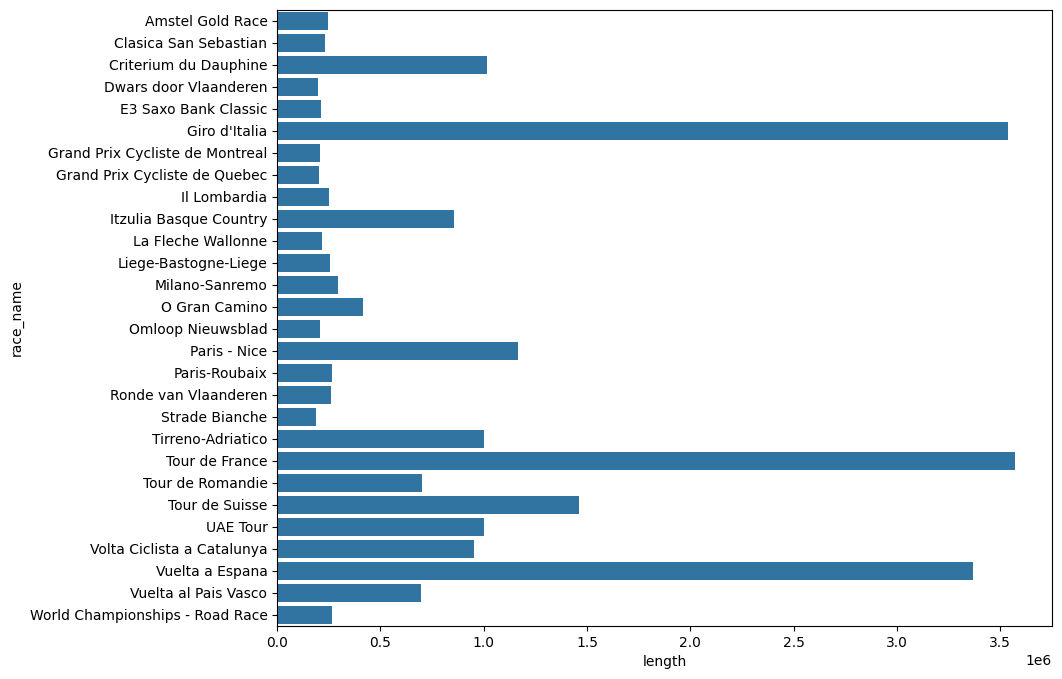

In [63]:
tmp_df = pd.DataFrame({
    'race_name': join_df['race_name'],
    'race_url': join_df['race_url'],
    'year': years,
    'length': join_df['length']
}).drop_duplicates()

tmp_sum = tmp_df.groupby(['year', 'race_name'])['length'].sum().reset_index()

tmp_mean = tmp_sum.groupby('race_name')['length'].mean().reset_index() #TODO: trovare plot più adatto da un punto di vista rappresentativo (stiamo plottando valori di attributi e non frequenze)

plt.figure(figsize=(10, 8))
sb.barplot(y='race_name', x='length', data=tmp_mean, orient='h')

Il plot di sopra mostra la media (rispetto agli anni) delle lunghezze di ogni gara presente nel nostro dataset. Abbiamo deciso di verificare online questi valori per confermare il funzionamento della nostra analisi, ricerca che ha avuto esito positivo. 

Da questo grafico emerge che il Giro di Italia, Tour de France e Vuelta a Espana siano le corse più lunghe, oltre a ciò però ci teniamo a sottolineare la similarità col grafico visto in precedenza (numero medio di stage per gara) in quanto a una lunghezza maggiore dell'intero percorso corrisponde anche un numero maggiore (apparentemente proporzionato) di stage in cui lo stesso percorso è suddiviso. Indagheremo meglio questa relazione da un punto di vista statistico

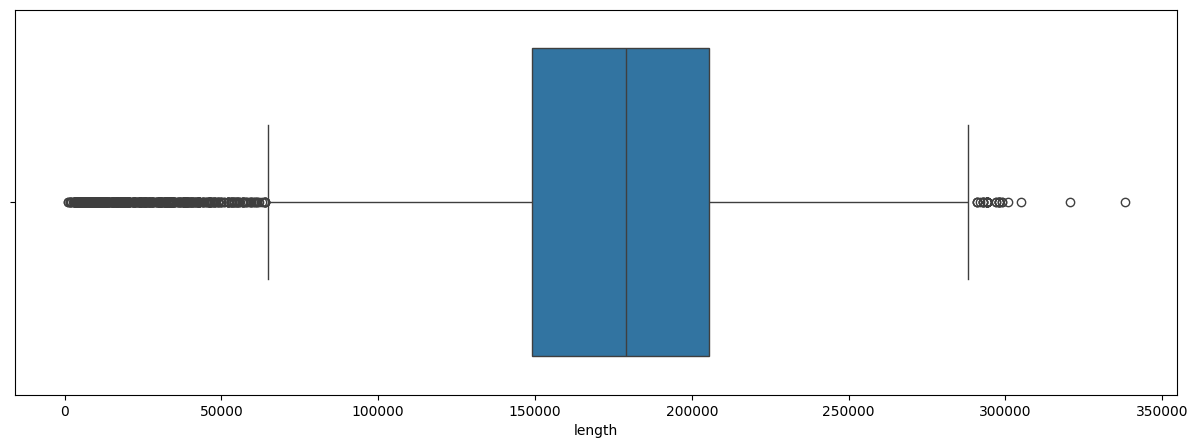

In [64]:
# MODIFICHE DEL 30-10


plt.figure(figsize=(15, 5))
sb.boxplot(x='length', data=tmp_df)
plt.show()

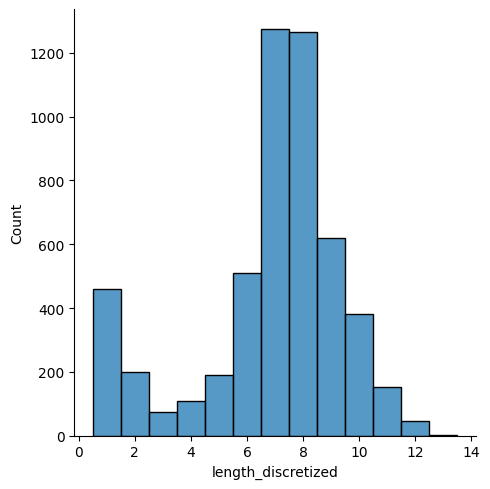

In [56]:
N = len(tmp_df[tmp_df['length'].notnull()])
bins = int(1 + 10/3 * math.log10(N))

tmp_df['length_discretized'] = pd.cut(tmp_df['length'], bins=bins, labels=[i for i in range(1, bins+1)])

sb.displot(tmp_df, 
                x="length_discretized", 
                kind="hist",
                row_order="desc",
                bins=len(tmp_df['length_discretized'].unique()))

In [57]:
tmp_df['length_discretized'].value_counts(normalize=True).sort_index()

length_discretized
1     0.087105
2     0.037682
3     0.014012
4     0.020261
5     0.035978
6     0.096762
7     0.241242
8     0.239538
9     0.117402
10    0.072145
11    0.028593
12    0.008900
13    0.000379
Name: proportion, dtype: float64

### Climb Total Attribute

<Axes: xlabel='climb_total', ylabel='race_name'>

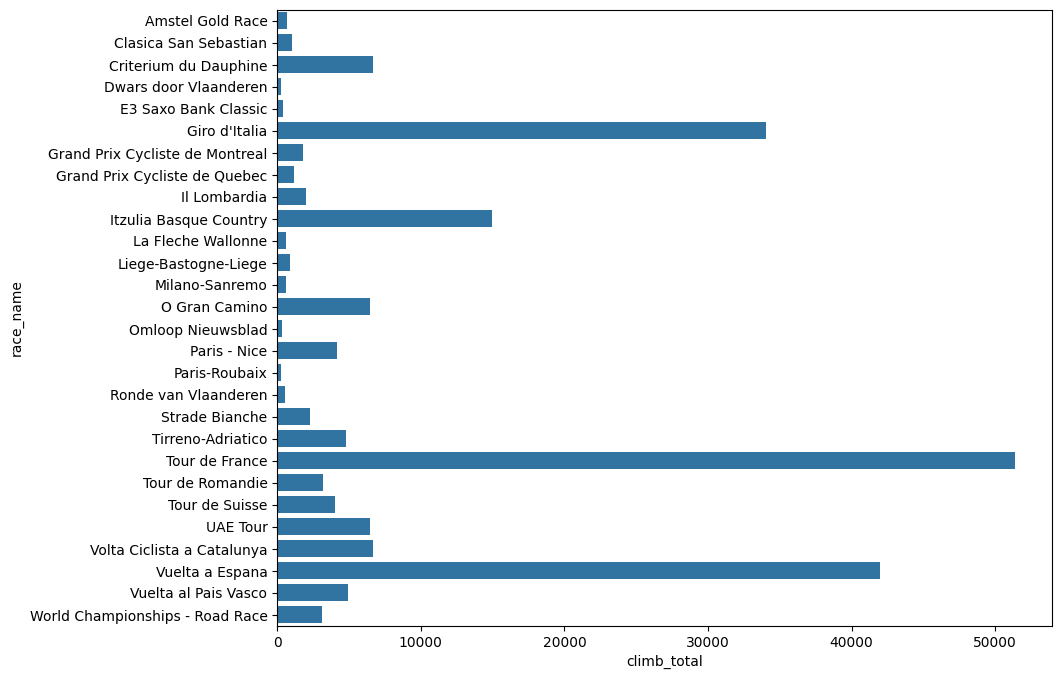

In [66]:
tmp_df = pd.DataFrame({
    'race_name': join_df['race_name'],
    'race_url': join_df['race_url'],
    'year': years,
    'climb_total': join_df['climb_total']
}).drop_duplicates()

tmp_sum = tmp_df.groupby(['year', 'race_name'])['climb_total'].sum().reset_index()

tmp_mean = tmp_sum.groupby('race_name')['climb_total'].mean().reset_index() #TODO: trovare plot più adatto da un punto di vista rappresentativo (stiamo plottando valori di attributi e non frequenze)

plt.figure(figsize=(10, 8))
sb.barplot(y='race_name', x='climb_total', data=tmp_mean, orient='h')

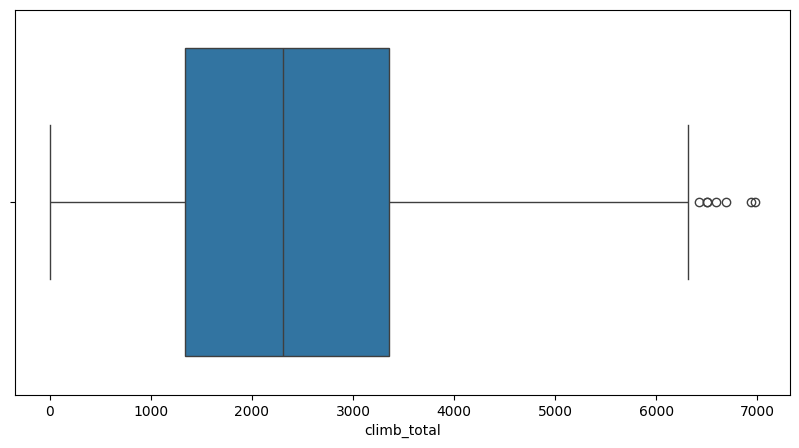

In [67]:
plt.figure(figsize=(10, 5))
sb.boxplot(x='climb_total', data=tmp_df)
plt.show()

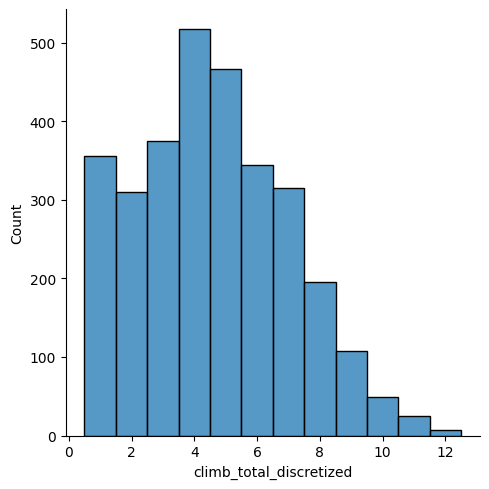

In [77]:
N = len(tmp_df[tmp_df['climb_total'].notnull()])
bins = int(1 + 10/3 * math.log10(N))

tmp_df['climb_total_discretized'] = pd.cut(tmp_df['climb_total'], bins=bins, labels=[i for i in range(1, bins+1)])

sb.displot(tmp_df, 
                x="climb_total_discretized", 
                kind="hist",
                row_order="desc",
                bins=len(tmp_df['climb_total_discretized'].unique()))

#plt.xticks(rotation=90);

In [70]:
tmp_df['climb_total_discretized'].value_counts(normalize=True).sort_index()

climb_total_discretized
1     0.116074
2     0.101076
3     0.122269
4     0.168569
5     0.151940
6     0.112162
7     0.102706
8     0.063580
9     0.035214
10    0.015977
11    0.008151
12    0.002282
Name: proportion, dtype: float64

### Profile Attribute

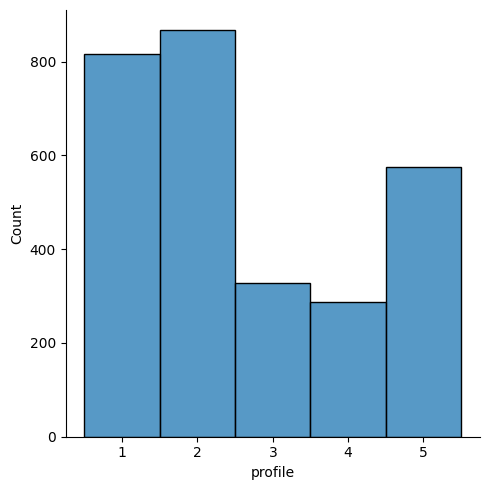

In [89]:
tmp_df = pd.DataFrame({
    'race_name': join_df['race_name'],
    'race_url': join_df['race_url'],
    'year': years,
    'profile': join_df['profile']
}).drop_duplicates().dropna()

sb.displot(tmp_df, 
                x="profile", 
                kind="hist",
                row_order="desc",
                bins=len(tmp_df['profile'].unique()))

In [84]:
tmp_df['profile'].value_counts(normalize=True).sort_index()

profile
1.0    0.284372
2.0    0.301775
3.0    0.113818
4.0    0.099896
5.0    0.200139
Name: proportion, dtype: float64

### Position Attribute

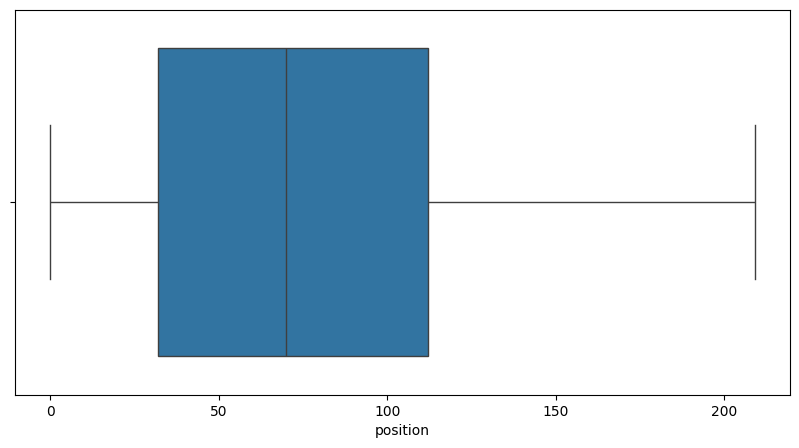

In [93]:
tmp_df = pd.DataFrame({
    'race_name': join_df['race_name'],
    'race_url': join_df['race_url'],
    'year': years,
    'position': join_df['position']
}).drop_duplicates().dropna()

plt.figure(figsize=(10, 5))
sb.boxplot(x='position', data=tmp_df)
plt.show()

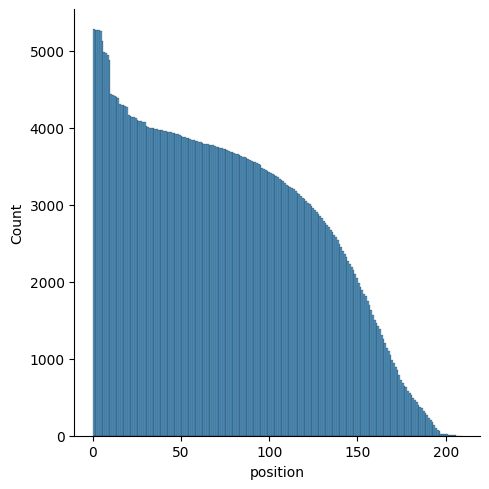

In [94]:
sb.displot(tmp_df, 
                x="position", 
                kind="hist",
                row_order="desc",
                bins=len(tmp_df['position'].unique()))

<Axes: xlabel='Mean number of positions', ylabel='race_name'>

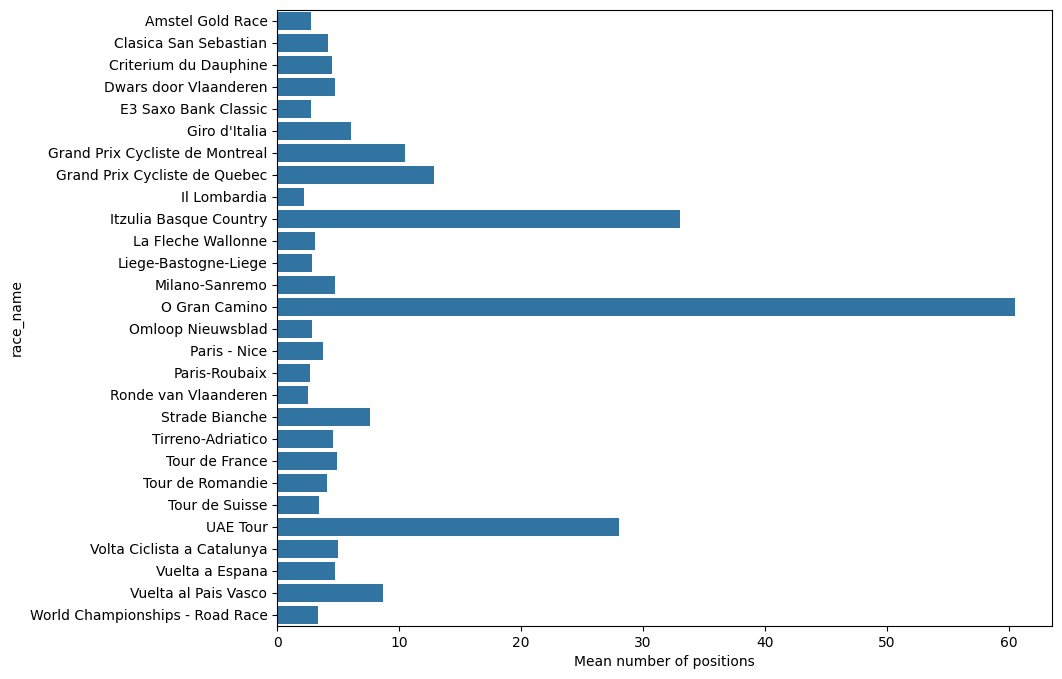

In [95]:
sum_race_positions_per_years = join_df.groupby('race_name')['position'].nunique()

mean_race_positions = sum_race_positions_per_years / n_years_per_race

mean_race_df = mean_race_positions.reset_index()

plt.figure(figsize=(10, 8))
plt.xlabel('Mean number of positions')
sb.barplot(y='race_name', x=0, data=mean_race_df, orient='h')

### Delta Attribute

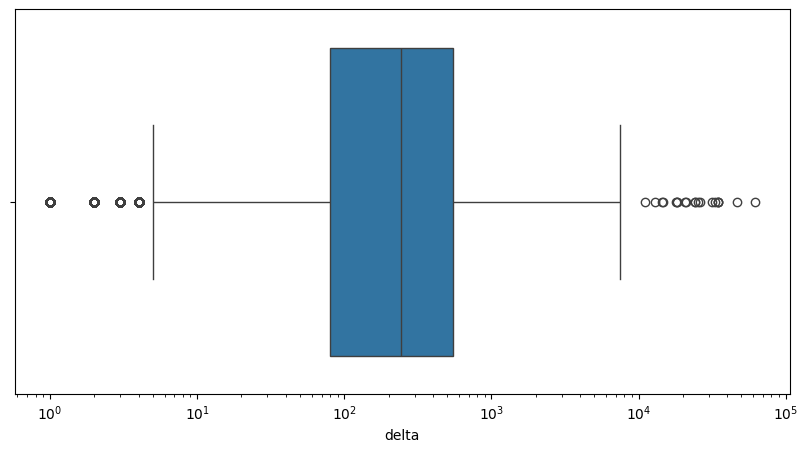

In [85]:
tmp_df = pd.DataFrame({
    'race_name': join_df['race_name'],
    'race_url': join_df['race_url'],
    'year': years,
    'delta': join_df['delta']
}).drop_duplicates().dropna()

plt.figure(figsize=(10, 5))
sb.boxplot(x='delta', data=tmp_df, log_scale=True) #TODO: capire se è giusto fare scala logariitmica
plt.show()

19


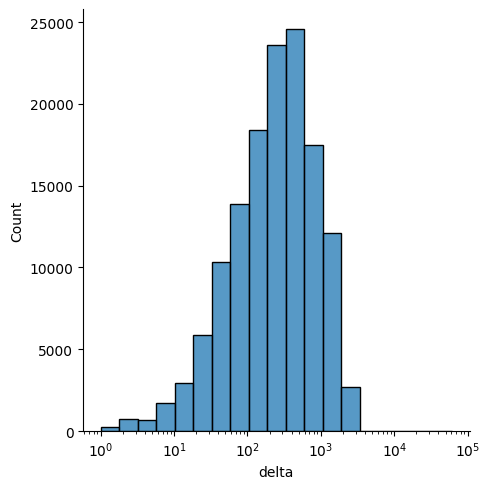

In [ ]:
N = len(tmp_df[tmp_df['delta'].notnull()])
bins = math.ceil(math.log2(N) + 1) #int(1 + 10/3 * math.log10(N))

#tmp_df['delta_discretized'] = pd.cut(tmp_df['delta'], bins=bins, labels=[i for i in range(1, bins+1)])

sb.displot(tmp_df, 
                x="delta", 
                kind="hist",
                row_order="desc",
                bins=bins,
                log_scale=True) #TODO: controllare se sia giusto fare scala logaritmica

## Feature Correlations